In [ ]:
from llava.model.builder import load_pretrained_model
from llava.mm_utils import get_model_name_from_path
from llava.eval.run_llava import eval_model

model_path = ""
tokenizer, model, image_processor, context_len = load_pretrained_model(
    model_path=model_path,
    model_base=None,
    model_name=get_model_name_from_path(model_path)
)


/home/wangsudong/anaconda3/envs/llava/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
You are using a model of type llava to instantiate a model of type llava_llama. This is not supported for all configurations of models and can yield errors.
Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]/home/wangsudong/anaconda3/envs/llava/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


/home/wangsudong/LLaVA/transformers-4.37.2/src/transformers/generation/configuration_utils.py:392: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/wangsudong/LLaVA/transformers-4.37.2/src/transformers/generation/configuration_utils.py:397: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `None` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


The color of the flower is yellow. tensor([[    1,   450,  2927,   310,   278, 28149,   338, 13328, 29889,     2]],
       device='cuda:0')
The color of the flower is pink. tensor([[    1,   450,  2927,   310,   278, 28149,   338,   282,   682, 29889,
             2]], device='cuda:0')
The color of the flower is white. tensor([[    1,   450,  2927,   310,   278, 28149,   338,  4796, 29889,     2]],
       device='cuda:0')
The color of the flower is red. tensor([[    1,   450,  2927,   310,   278, 28149,   338,  2654, 29889,     2]],
       device='cuda:0')
The color of the flower is purple. tensor([[    1,   450,  2927,   310,   278, 28149,   338,  3708,   552, 29889,
             2]], device='cuda:0')
The color of the flower is white. tensor([[    1,   450,  2927,   310,   278, 28149,   338,  4796, 29889,     2]],
       device='cuda:0')


The color of the flower is pink. tensor([[    1,   450,  2927,   310,   278, 28149,   338,   282,   682, 29889,
             2]], device='cuda:0')
The color of the flower is purple. tensor([[    1,   450,  2927,   310,   278, 28149,   338,  3708,   552, 29889,
             2]], device='cuda:0')
The color of the flower is red. tensor([[    1,   450,  2927,   310,   278, 28149,   338,  2654, 29889,     2]],
       device='cuda:0')
The color of the flower is pink. tensor([[    1,   450,  2927,   310,   278, 28149,   338,   282,   682, 29889,
             2]], device='cuda:0')
The color of the flower is red. tensor([[    1,   450,  2927,   310,   278, 28149,   338,  2654, 29889,     2]],
       device='cuda:0')
The color of the flower is yellow. tensor([[    1,   450,  2927,   310,   278, 28149,   338, 13328, 29889,     2]],
       device='cuda:0')


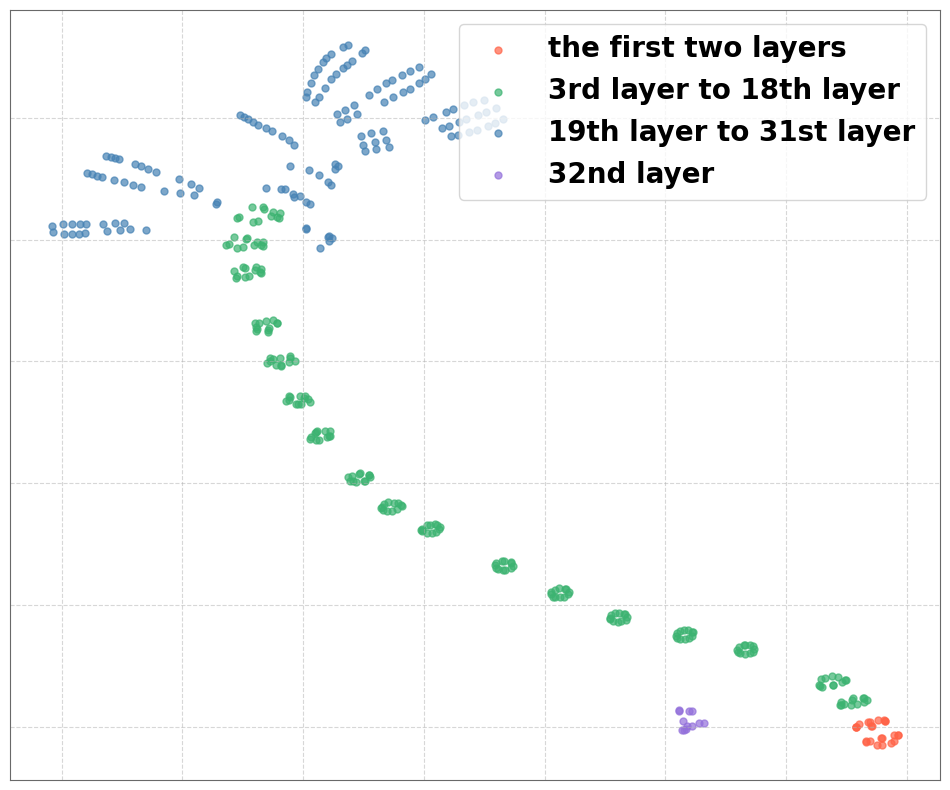

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MaxAbsScaler
from sklearn.manifold import TSNE
from matplotlib.colors import to_hex

# List to store hidden states corresponding to the token of interest for each image.
token_hidden_states = []
num_images = 12  # Total number of images to process

# Loop over each image.
for i in range(num_images):
    image_file = f"/image/flower/flower{i+1}.jpg"
    prompt = 'What is the color of the flower?'  # Prompt can be adjusted as needed  ##"What is the color of the flower? The color of the flower is" 
    args = type('Args', (), {
        "model_base": None,
        "model_name": get_model_name_from_path(model_path),
        "query": prompt,
        "conv_mode": None,
        "image_file": image_file,
        "sep": ",",
        "temperature": 0,
        "top_p": None,
        "num_beams": 1,
        "max_new_tokens": 256,
        "model": model,
        "tokenizer": tokenizer,
        "image_processor": image_processor,
        "output_hidden_states": True,
        "return_dict_in_generate": True,
    })()

    all_output = eval_model(args)
    output_text = tokenizer.decode(all_output['sequences'][0], skip_special_tokens=True)
    
    # Print the model output for debugging
    print(output_text, all_output['sequences'])
    
    # Define the token position to analyze (e.g., token "color" is at index 6).
    location = 6
    hidden_states = all_output["hidden_states"]
    dataset = []
    
    # Loop over time steps for the specified token location.
    # If location == 0, use the last token's hidden state; otherwise, use the full hidden state.
    for t in range(len(hidden_states[0])):
        if location == 0:
            state = hidden_states[location][t][:, -1, :]
            dataset.append(np.squeeze(state.cpu().numpy()))
        else:
            dataset.append(np.squeeze(hidden_states[location][t].cpu().numpy()))
    
    # Remove the first token (usually a special token like </s>) and store the hidden states.
    token_hidden_states.append(np.array(dataset)[1:, :])

# Stack the hidden states from all images vertically.
data_array = np.vstack(token_hidden_states)

# Normalize the data using MaxAbsScaler.
scaler = MaxAbsScaler()
data_flat_scaled = scaler.fit_transform(data_array)

def generate_colors(cmap_name, num_colors):
    """
    Generate a list of hex color codes from a specified Matplotlib colormap.

    Args:
        cmap_name (str): Name of the colormap (e.g., 'Blues_r').
        num_colors (int): Number of colors to generate.

    Returns:
        List[str]: List of hex color codes.
    """
    cmap = plt.get_cmap(cmap_name, num_colors)
    return [to_hex(cmap(i)) for i in range(num_colors)]

# Define labels for each group of layers.
# For the 7b model, labels correspond to:
# 0 -> first 2 layers, 1 -> layers 3 to 19, 2 -> layers 20 to 31, 3 -> 32nd layer.
labels_per_array = np.concatenate([
    np.repeat(0, 2),
    np.repeat(1, 17),
    np.repeat(2, 12),
    np.repeat(3, 1),
])
# For a 13b model, use these labels instead:
# labels_per_array = np.concatenate([
#     np.repeat(0, 2),
#     np.repeat(1, 17),
#     np.repeat(2, 20),
#     np.repeat(3, 1),
# ])

# Repeat the label array for each image.
labels_flat = np.tile(labels_per_array, num_images)

# Ensure the total number of labels matches the number of data samples.
assert len(labels_flat) == data_flat_scaled.shape[0], "Mismatch between labels and data samples."

# Apply t-SNE for dimensionality reduction to 2D.
tsne = TSNE(n_components=2, perplexity=35, learning_rate=200, n_iter=2000, random_state=0)
data_tsne = tsne.fit_transform(data_flat_scaled)

# Define names for each label group.
label_names = [
    'the first two layers',
    '3rd layer to 18th layer',
    '19th layer to 31st layer',
    '32nd layer'
]

# Define a set of colors for plotting.
colors = ['#FF6347', '#3CB371', '#4682B4', '#9370DB', 
          '#FFA07A', '#FFDAB9', '#87CEFA', '#FFB6C1']

# Create a t-SNE scatter plot.
plt.figure(figsize=(12, 10))
for i, label in enumerate(np.unique(labels_flat)):
    idx = labels_flat == label
    plt.scatter(
        data_tsne[idx, 0],
        data_tsne[idx, 1],
        color=colors[i],
        label=label_names[i],
        s=25,
        alpha=0.7
    )

# Remove axis ticks and labels for a cleaner look.
plt.tick_params(
    axis='both',
    which='both',
    bottom=False,
    top=False,
    labelbottom=False,
    left=False,
    right=False,
    labelleft=False
)

# Customize the plot spines (borders).
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_color('dimgray')
    spine.set_linewidth(0.8)

# Add legend and grid.
plt.legend(loc='upper right', prop={'size': 20, 'weight': 'bold'})
plt.grid(True, linestyle='--', alpha=0.5, zorder=0.1)

# Save and display the plot.
# plt.savefig('color_combine_animal.png', bbox_inches='tight', pad_inches=0.1)
plt.show()
